# Clustering Notebook in R

Notes and References 

sample size for clustering
https://journals.sagepub.com/doi/full/10.1177/0047287513496475


In [140]:
# Import the necessary Libraries to run all the clustering algorithms 
library(clustMixType)
library(e1071)
library(caTools)
library(caret)
library(nnet)
library(tidyr)
library(forecast)
library(FactoMineR)
library(dplyr)
library(MASS)
library(moments)
library(readxl)
library(e1071)
library(factoextra)
library(ClusterR)
library(ggplot2)
library(wesanderson)
library(randomForest)
library(mclust)
library(NbClust)
library(kableExtra)
library(PCAmixdata)
library(factoextra)
library(reshape2)
library(bestNormalize)
library(PerformanceAnalytics)
library(corrplot)
library(descr)
library(gridExtra)
library(cluster)
library(h2o)
library(purrr)
h2o.init(nthreads = 5)
library(openxlsx)
library(xgboost)
library(ggpubr)

# Other Configurations for Jupyter Notebook
options(jupyter.plot_scale=1)  # sets the plot size

 Connection successful!

R is connected to the H2O cluster: 
    H2O cluster uptime:         1 hours 9 minutes 
    H2O cluster timezone:       America/Los_Angeles 
    H2O data parsing timezone:  UTC 
    H2O cluster version:        3.32.0.1 
    H2O cluster version age:    1 month and 23 days  
    H2O cluster name:           H2O_started_from_R_rcluk_xeo316 
    H2O cluster total nodes:    1 
    H2O cluster total memory:   3.48 GB 
    H2O cluster total cores:    8 
    H2O cluster allowed cores:  5 
    H2O cluster healthy:        TRUE 
    H2O Connection ip:          localhost 
    H2O Connection port:        54321 
    H2O Connection proxy:       NA 
    H2O Internal Security:      FALSE 
    H2O API Extensions:         Amazon S3, Algos, AutoML, Core V3, TargetEncoder, Core V4 
    R Version:                  R version 4.0.3 (2020-10-10) 



# Build Functions
These functions are necessary to build the algorithm and transform the data.  Do not change or modify these functions! 
<hr>

*h2o_glrm* - this function compresses the dataset (variables) down to k dimensions - recommend 2 or 3 <br>
*famd_pca* - this function is similar to the first one, but uses a different algorithm; it's not as good as the first one <br>
*make_cluster* - this function runs three different clustering algorithms on the dimension-reduced data <br>
*rf_valid* - this function runs the random-forest and ANOVA validation on the final cluster solutions <br>
<hr>

In [141]:
# Build Functions to process the data

# this function uses Generalized Low Rank Model to reduce multivariate mixed data to k dimensions
h2o_glrm <- function(data, k) {
    df_h2o <- as.h2o(data)
    m_glrm = h2o.glrm(training_frame = df_h2o, loss = "Quadratic", gamma_x = .25, gamma_y = 1, transform = "standardize", k = k,
                  seed = 123, max_iterations = 1000, recover_svd=TRUE, init="SVD",
                      regularization_x = "L1",
                      regularization_y = "L1")
    X.m = as.data.frame(h2o.getFrame(m_glrm@model$representation_name))
    return(X.m)
}

famd_pca <- function(data, k) {
    PCA_famd <-FAMD(data, ncp=k, graph=FALSE)
    y <- get_famd_ind(PCA_famd)
    df_famd <- as.data.frame(y$coord)
    return(df_famd)
}

# Function to perform various clustering algorithms
make_cluster <- function(data, k, meth) {
    tot_withinss = map_dbl(1:10, function(k)
      {
      model=kmeans(x = data, centers = k)
      model$tot.withinss
      })

    elbow_df <- data.frame(k = 1:10, tot_withinss = tot_withinss)

    plot1 <- ggplot(elbow_df, aes(x = k, y = tot_withinss)) + geom_line() +
      scale_x_continuous(breaks = 1:10)
     
    if(meth == 'kmeans'){
        set.seed(45)
        model_cl = kmeans(data, k, nstart = 25)
        plot2 <- fviz_cluster(model_cl, data = data, geom = 'point')
        clusters <- model_cl$cluster
        sil <- silhouette(model_cl$cluster, dist(data))
        }
    
    else if(meth == 'gmm'){
        gmm = GMM(data, k, dist_mode = "eucl_dist", seed_mode = "random_subset", km_iter = 15, em_iter = 15, verbose = F)
        pr <- predict_GMM(data, gmm$centroids, gmm$covariance_matrices, gmm$weights)
        clusters <- pr$cluster_labels
        plot2 <- ggplot() + geom_point(data = data, mapping = aes(x = data[,1], y = data[,2], col = as.factor(pr$cluster_labels))) + scale_fill_brewer(palette="Set1")
        sil <- silhouette(pr$cluster_labels, dist(data))
        }
    
    else if(meth == 'hier'){
        # Dissimilarity matrix
        d <- dist(data, method = "minkowski", p=5)

        # Hierarchical clustering using Complete Linkage
        hc1 <- hclust(d, method = "ward.D2" )
        clusters <- cutree(hc1, k = k)
        plot2 <- ggplot() + geom_point(data = data, mapping = aes(x = data[,1], y = data[,2], col = as.factor(clusters))) + scale_fill_brewer(palette="Set1")
        sil <- silhouette(clusters, dist(data))
        }
    plot3 <- fviz_silhouette(sil)
    
    return(list(plot1, plot2, plot3, clusters))
}

# Function to perform Validation using Random Forest and ANOVA
rf_valid <- function(clusters, data, trees, depth) {
    c <- clusters
    df_crm1 = as.data.frame(data)
    df_crm1$clusters <- c
    df_crm1$clusters <- as.factor(df_crm1$clusters)
    df_rf <- as.h2o(df_crm1)
    
    # Random Forest 
    predictors <- c("thry_day_es_n", "env_purch_n", "env_sent_life_n", "num_trx_n", "mmr_n")
    response <- "clusters"
    
    dfr_split <- h2o.splitFrame(data = df_rf, ratios = 0.65, seed = 1234)
    train <- dfr_split[[1]]
    valid <- dfr_split[[2]]
    
    
    # Build and train the model:
    ds_drf <- h2o.randomForest(x = predictors,
                             y = response,
                             ntrees = trees,
                             balance_classes=TRUE,
                             stopping_metric = "AUTO",
                             stopping_rounds = 20, 
                             stopping_tolerance = 0.001,
                             histogram_type='RoundRobin',
                             sample_rate = .6,
                             col_sample_rate_per_tree = .75,
                             nbins=25,
                             mtries=-1,
                             max_depth = depth,
                             min_rows = 1,
                             nfolds = 10,
                             training_frame = train,
                             validation_frame = valid)
    
    cm1 <- h2o.confusionMatrix(ds_drf)
    cm2 <- h2o.confusionMatrix(ds_drf, valid)
    varimp <- h2o.varimp(ds_drf)

    return(list(ds_drf, df_crm1, cm1, cm2, varimp))
}

In [142]:
run_h2 <- function(data, comp, clust, algo, trees, depth) {
    h2o_pca <- h2o_glrm(data, comp)
    famd_pca <- famd_pca(data, comp)
    cl <- make_cluster(h2o_pca, clust, algo)
    cluster_plot <- cl[[2]]
    elbow_plot <- cl[[1]]
    sil_plot <- cl[[3]]
    clusters <- cl[[4]]
    val <- rf_valid(cl[[4]], as.data.frame(df_crm_i), trees, depth)
    #val <- rf_valid(oc, as.data.frame(df_crm_i))
    return(list(val,cluster_plot, elbow_plot, sil_plot, clusters))
}


# Load the Data Set 
<hr>
The data has had pre-processed in Excel - namely to remove certain values (i.e. Real Estate, Free Accounts, etc.) and to recombine some levels in the Categorical variables due to low counts (i.e. less than 5).  The following modifications were made:<br><br>
1. "Former Customers" were excluded <br>
2. Vertical: Real-estate were excluded <br>
3. Non-Paying customers were removed <br> 
4. Pricing Model = Free were removed <br>
5. customers from the survey that could not be found in the CRM data were removed <br>
<hr>

In [143]:
# Load the Data
df <- read_excel("C:/Users/rcluk/Python_Projects/p202/new_ds_data_clean_v3.xlsx")
head(df) # just show the first couple of lines to confirm that the data loaded properly
dim(df) # check the dimensions - there should be 1118 rows of respondents and 38 variables (columns)

uid,q1,q2,q3,q4,q5,q6,q7,q8,q9,...,q30,q32,q33,q34,q35,q36,q37,q38i,q39i,q40i
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
6,1,0,0,10,6,1,4,500,500,...,19470,135054,515,89,85740,830,9388.89,515,89,830
7,1,1,1,2,5,2,4,10,30,...,357,374,450,85,2101,213,350.62,450,85,213
8,1,0,0,4,4,2,4,6,6,...,528,768,1098,0,150,269,481.25,1098,NA,269
10,1,1,1,5,3,1,4,200,200,...,7321,24382,650,40,7603,99,7793.30,650,40,99
11,1,0,0,9,6,2,4,8,100,...,4985,5032,2000,92,1025,324,21457.50,2000,92,324
12,0,1,0,6,5,2,2,200,1000,...,59125,253718,115,30,249291,130,48369.83,115,30,130


[1] 1123   46

# Variable Definitions 
<hr>
##### SURVEY VARIABLES <br>
Unique_order: a unique identifier for each participant <br>
q1:   US Locuation (cat) <br>
q2:   Non-Us Location (cat) <br>
q3:   both US/Non-US Location (cat) <br>
q4:   count of departments using DocuSign (scale)                  |  Survey Q18 <br>
q5:   Feature Usage (scale)                                        |  Survey Q28 <br>
q5a:  Feature Usage Binned (cat)                                   |  recoded (based on clustering of responses, see SPSS note) <br>
q6:   count of roles of DocuSign users (scale)                     |  Survey Q19 <br>
q7:   count of admin portal feature usage (scale)                  |  Survey Q26 <br>
q8:   number of unique senders managed (scale)                     |  Survey Q51 <br>
q9:   number of unique senders in company (scale)                  |  Survey Q13 <br>
q10:  number of DocuSign accounts (scale)                          |  Survey Q14 <br>
q11:  % of time on DocuSign activities in the month (scale)        |  Survey Q24_4 <br>
q11a: q11 binned into timeframe buckest [0 = 1, 2 < 50, 3 > 50]    |  recoded <br>
q12:  level of satisfaction with DocuSign experience (scale)       |  Survey Q37 <br>
q13:  level of confidence in getting the most out of DS (scale)    |  Survey Q21 <br>
q14:  Top 2 Targeted Outcomes of your role with DocuSign (cat)     |  Survey Q10 <br>
q15:  number of locations (cat)                                    |  Survey Q2 <br>
q16:  Your level of responsibility (cat)                           |  Survey Q7 <br>
q17:  Top Group from: % of Time on each responsibility (cat)       |  Survey Q9 <br>
q18:  level of DocuSign expertise (cat)                            |  Survey Q20 <br>
q19:  Sphere of Influence (cat)                                    |  Survey Q22 <br>
q20:  How long have you been working with DocuSign (cat)           |  Survey Q23 <br>
q21:  How often do you interact with the DocuSign platform (cat)   |  Survey Q26 <br>
q22:  Which best describes your DocuSign role (cat)                |  Survey Q47 <br>
q23:  do you consider yourself to be a DocuSign admin (cat)        |  Survey Q48  <br>
q24:  what department of your company do you work in? (cat)        |  Survey Q5 <br>
q25: <br>
q26: <br>
<br>
<br>
##### CRM Variables <br>
q25:  Account Type (cat)                                           |  CRM <br>
q26:  Vertical (cat)                                               |  CRM <br>
q27:  MMR                                                          |  CRM <br>
q28:  number of employees                                          |  CRM <br>
q29:  adoption index                                               |  CRM <br>
q30:  ThitryD Envelopes Send                                       |  CRM <br>
q31:  Envelopes Purchased                                          |  CRM <br>
q32:  Envelopes_sent_in_term                                       |  CRM <br>


# Exploratory Data Analysis

In [144]:
df_e <- psych::describe(df)
round(df_e, 3)

,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
uid,1,1123,845.045,463.324,868.0,852.764,581.179,6,1618,1612,-0.128,-1.161,13.826
q1,2,1123,0.915,0.280,1.0,1.000,0.000,0,1,1,-2.961,6.774,0.008
q2,3,1123,0.240,0.427,0.0,0.175,0.000,0,1,1,1.219,-0.515,0.013
q3,4,1123,0.159,0.365,0.0,0.073,0.000,0,1,1,1.868,1.489,0.011
q4,5,1123,3.387,2.447,3.0,3.057,2.965,0,13,13,1.165,1.252,0.073
q5,6,1123,3.516,2.110,3.0,3.277,1.483,1,12,11,1.046,1.196,0.063
q6,7,1123,1.629,0.951,1.0,1.443,0.000,1,6,5,1.836,3.828,0.028
q7,8,1123,2.866,1.461,3.0,2.763,1.483,1,7,6,0.422,-0.631,0.044
q8,9,1123,42.265,198.963,5.0,9.567,4.448,0,3000,3000,10.974,143.537,5.937


Summary 

Among the numeric variables, significant skew is observed in the folowing variables:  q4, q6, q8, q9, q10, q11, q12.  These variables should be transformed prior to being included in the analysis. 

The CRM variables (q27 - q33) also show severe skew (except q29); these will all need to be transformed before further analysis.  

# Evaluate Variables for Skew


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



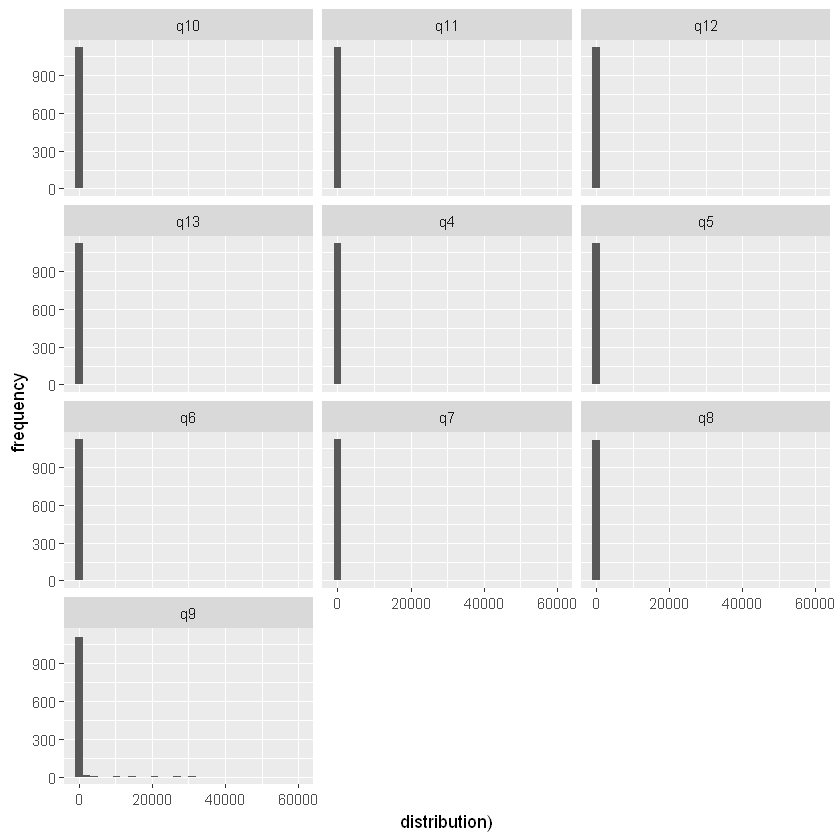

In [8]:
# the code below shows the distribution of the original, untransformed quant variables from the survey.  The results show
# the presence of significant skew in all the variables.  This is problematic for distance-based clustering algoithms such as kmeans
# hierarchical methods.  The variables need to be transformed to better approximate a Normal distribution of each variable. 
cols <- c("q4", "q5", "q6", "q7", "q8", "q9", "q10", "q11", "q12", "q13")

df %>% 
  pivot_longer(q4:q13, names_to = "question", values_to = "response") %>% 
  ggplot(aes(x = response)) +
  geom_histogram() +
  facet_wrap(vars(question), ncol = 3) +
  labs(x = "distribution)", y = "frequency")

# apply the transformation and save to new dataframe
test_df <- lapply(df[cols], bestNormalize)
q4t<- test_df$q4[[1]]
q5t<- test_df$q5[[1]]
q6t<- test_df$q6[[1]]
q7t<- test_df$q7[[1]]
q8t<- test_df$q8[[1]]
q9t<- test_df$q9[[1]]
q10t<- test_df$q10[[1]]
q11t<- test_df$q11[[1]]
q12t<- test_df$q12[[1]]
q13t<- test_df$q13[[1]]
df_t = as.data.frame(cbind(q4t, q5t, q6t, q7t, q8t, q9t, q10t, q11t, q12t, q13t))

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



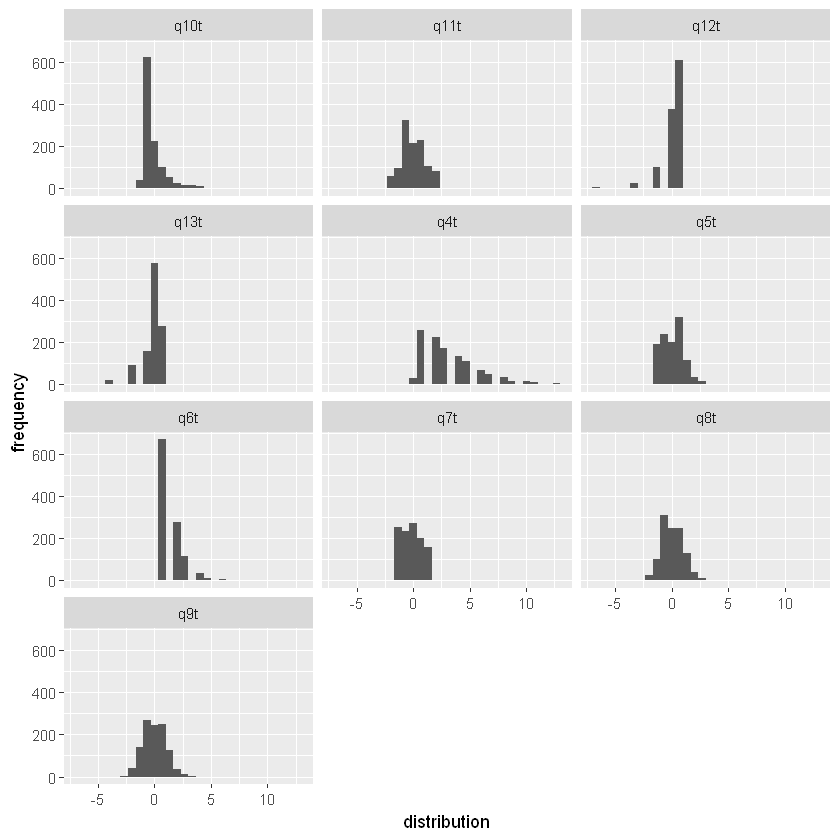

In [9]:
# the plots below show the result after applying the optimal normalization method to each variable.  The R Package 'bestNormalize' 
# is a convenient package that applies a number of various transformations to each variable and then selects the transformation
# which yields the best approach - best in this case means closest to a Gaussian distribution. 

df_t %>% 
  pivot_longer(q4t:q13t, names_to = "question", values_to = "response") %>% 
  ggplot(aes(x = response)) +
  geom_histogram() +
  facet_wrap(vars(question), ncol = 3) +
  labs(x = "distribution", y = "frequency")

<hr>

# Transform All Variables
The code in this blocks transforms all the numeric variables to remove skew, and the re-combines all the numeric and categorical variables into the final dataframe for analysis
<hr>

In [41]:
# SCALE VARIABLES #####################################################################################
# Scale Variables (n = 10)

q4n <- df$q4 %>% bestNormalize() %>% .[[1]]  # count of departments using Docusign (q18)
q5n <- df$q5 %>% bestNormalize() %>% .[[1]]  # number of Docusign features used (q28)
q6n <- df$q6 %>% bestNormalize() %>% .[[1]]  # count of roles of docusign users (q19)
q7n <- df$q7 %>% bestNormalize() %>% .[[1]]  # count of admin portal features used (q27)
q8n <- df$q8 %>% bestNormalize() %>% .[[1]]  # number of unique senders managed (q51)
q9n <- df$q9 %>% bestNormalize() %>% .[[1]]  # number of unique senders in company (q13)
q10n <- df$q10 %>% bestNormalize() %>% .[[1]] # number of docusign accounts (q14)
q11n <- df$q11 %>% bestNormalize() %>% .[[1]] # % time on DS activities each month (q24_4)
q12n <- df$q12 %>% bestNormalize() %>% .[[1]] # satisfaction with DS (q37)
q13n <- df$q13 %>% bestNormalize() %>% .[[1]] # confidence level with DS (q21)

df_scale <- cbind(df$q4, df$q5, df$q6, df$q7, df$q8, df$q9, df$q10, df$q12, df$q13)


#Label numeric variables for convenience: 
depts_using <- q4n
feat_used <- q5n
num_roles <- q6n
admin_prtl_use <- q7n
unq_snd_mng <- q8n
unq_snd_cmp <- q9n 
num_ds_accnts <- q10n
time_ds_act <- q11n
rate_sat <- q12n
rate_conf <- q13n


#Combine into new DataFrame
df_norm_s <- cbind(depts_using, feat_used, num_roles, admin_prtl_use, unq_snd_mng,unq_snd_cmp, rate_sat)


#CATEGORICAL VARIABLES #########################################################################################
# Survey Categorical Variables (n = 15)

q1  <- df$q1
q2  <- df$q2
q3  <- df$q3
num_locs <- df$q14 # Number of Locations
dept <- df$q15 # Your Department
job_level <- df$q16 # Level of Responsibility (Staff, Mid_management, VP, etc.)
time_resp <- df$q17 # % time spent on responsibilities (group)
time_ds_tasks <- df$q18 # % time DS Tasks (group)
top_two <- df$q19 # Top 2 outcomes for your role
ds_expr <- df$q20 # Level of DS Experience (Beginner, Int., Advanced)
sphere_resp <- df$q21 # Sphere of responsibility
time_using <- df$q22 # Time using DS in Role
freq_use <- df$q23 # Frequency of DS Use
ds_role <- df$q24 # Your DS Role
admin <- df$q25 # Consider yourself an Admin
ds_uni <- df$q26 # Use Docusign University
q28_grp <- df$q28_grp
q11_grp <- df$q11_grp
vert <- df$vertical
r_content <- df$rank_prefer_content
r_help <- df$rank_help_topics
r_comm <- df$rank_comm_method

# categorical variables
df_cat = as.data.frame(cbind(num_locs, dept, time_resp, time_ds_tasks, ds_expr, ds_role, ds_uni, vert))
df_c_s <- mutate_at(df_cat, vars(num_locs, dept, time_resp, time_ds_tasks, ds_expr, ds_role, ds_uni, vert), as.factor)


# CRM Variables ##################################################################################################

#CRM: original untransformed data
q28 <- df$q28
q29 <- df$q29
q30 <- df$q30 
q32 <- df$q32 
q33 <- df$q38i 
q34 <- df$q39i 
q35 <- df$q35
q36 <- df$q40i
q37 <- df$q37  


# transformed CRM variables to remove skew and normalize
thry_day_es_n <- df$q28 %>% bestNormalize() %>% .[[1]]
env_purch_n <- df$q29 %>% bestNormalize() %>% .[[1]]
env_sent_term_n <- df$q30 %>% bestNormalize() %>% .[[1]]
env_sent_life_n <- df$q32 %>% bestNormalize() %>% .[[1]]
num_empl_n <- df$q33 %>% bestNormalize() %>% .[[1]]
adp_indx_n <- df$q34 %>% bestNormalize() %>% .[[1]]
num_trx_n <- df$q35 %>% bestNormalize() %>% .[[1]]
days_cust_n <- df$q36 %>% bestNormalize() %>% .[[1]]
mmr_n <- df$q37 %>% bestNormalize() %>% .[[1]]
num_emp_imp <- df$q38i %>% bestNormalize() %>% .[[1]]  
adp_indx_imp <- df$q39i %>% bestNormalize() %>% .[[1]] 
days_cust_imp <- df$q40i %>% bestNormalize() %>% .[[1]]

df_crm_i <- cbind(thry_day_es_n, env_purch_n, env_sent_life_n, num_trx_n, mmr_n)


#New DataFrame for Analysis ######################################################################################

df_all = cbind(df_norm_s, df_c_s)

##################################################################################################################

# isolate the original clusters (from the previous vendor)
oc = factor(df$orig_clust)

# PCA to transform all the CRM variables into a single variable
crm_pca <- PCA(df_crm_i, scale.unit = FALSE, ncp = 1, graph = FALSE)
DV1 <- crm_pca$ind$coord

# Check Correlations and Shape of Data

In [12]:
df_h2o <- as.h2o(df_all)
m_glrm = h2o.glrm(training_frame = df_h2o, loss = "quadratic", gamma_x = 0, gamma_y = 1, transform = "standardize", k = 2,
              seed = 123, max_iterations = 1000, recover_svd=TRUE, init="SVD",
                  regularization_x = "L1",
                  regularization_y = "L1")
X.m = as.data.frame(h2o.getFrame(m_glrm@model$representation_name))

Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."


  |======================================================================| 100%
  |======================================================================| 100%


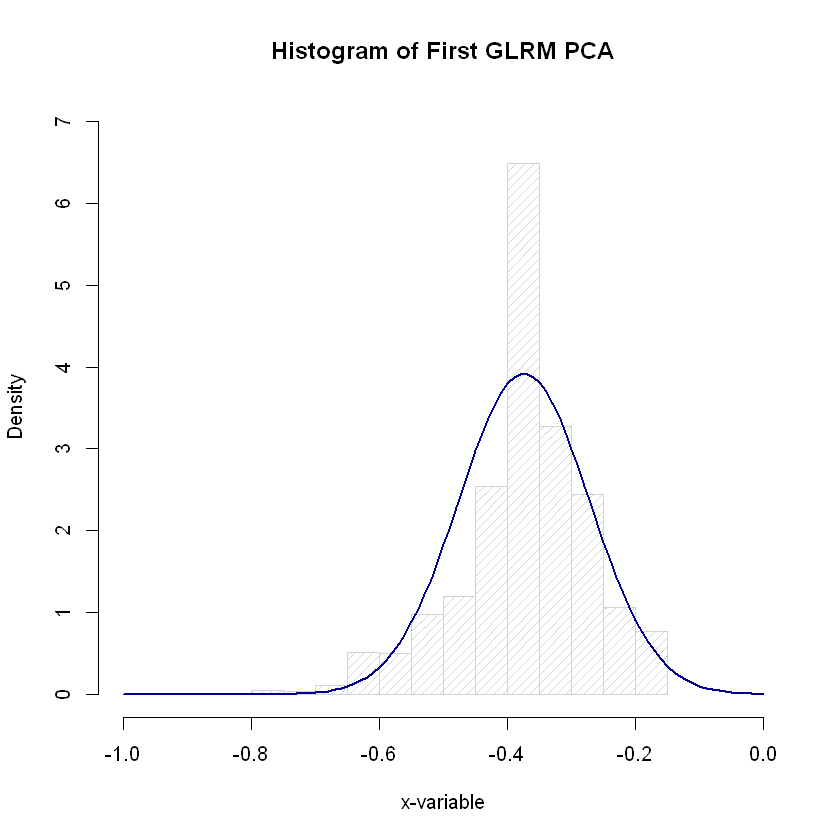

In [37]:
g = X.m$Arch1
m<-mean(g)
std<-sqrt(var(g))
hist(g, density=20, breaks=20, prob=TRUE, 
     xlab="x-variable", ylim=c(0, 7), xlim=c(-1,0), 
     main="Histogram of First GLRM PCA")
curve(dnorm(x, mean=m, sd=std), 
      col="darkblue", lwd=2, add=TRUE, yaxt="n")

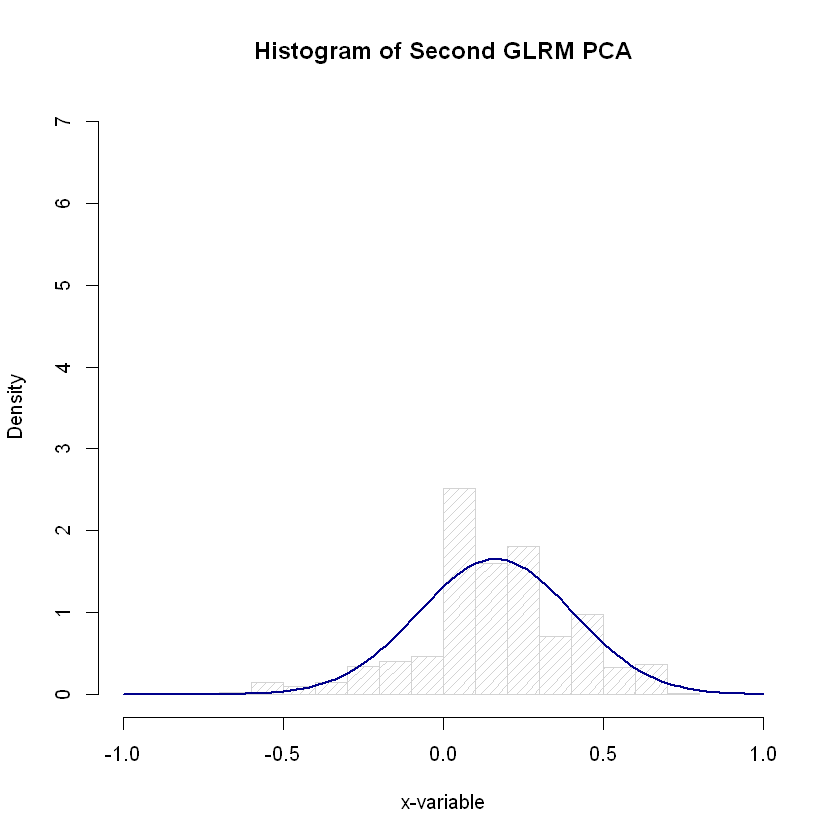

In [39]:

g2 = X.m$Arch2
m2<-mean(g2)
std<-sqrt(var(g2))
hist(g2, density=20, breaks=20, prob=TRUE, 
     xlab="x-variable", ylim=c(0, 7), xlim=c(-1,1), 
     main="Histogram of Second GLRM PCA")
curve(dnorm(x, mean=m2, sd=std), 
      col="darkblue", lwd=2, add=TRUE, yaxt="n")

# Calculuate the Hopkins Statistic (> .8 is good)

In [327]:
library(factoextra)
# Compute Hopkins statistic for iris dataset
h.stat <- get_clust_tendency(df_norm_s, n=1122)
h.stat$hopkins_stat

[1] 0.7568043

In [328]:
h.stat <- get_clust_tendency(X.m, n=1122)
h.stat$hopkins_stat

[1] 0.9081158

In [329]:
h.stat <- get_clust_tendency(df_crm, n=1122)
h.stat$hopkins_stat

[1] 0.7691544

# Variable Selection using Random Forest Regression


Call:
 randomForest(formula = df_var_sel$Dim.1 ~ ., data = df_var_sel,      ntree = 300, mtry = 4, nodesize = 4, maxnodes = 30, importance = TRUE,      na.action = na.omit) 
               Type of random forest: regression
                     Number of trees: 300
No. of variables tried at each split: 4

          Mean of squared residuals: 2.047011
                    % Var explained: 44.26

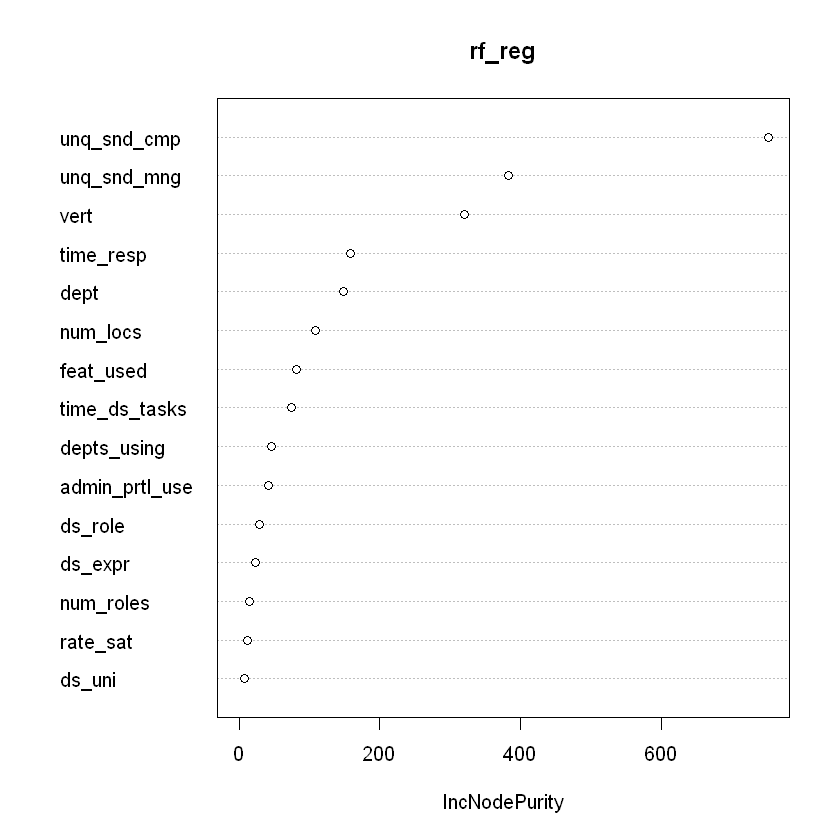

In [44]:
#Combine the DV (PCA of CRM variables) with the dataframe containing all variables
df_var_sel = cbind(DV1, df_all)
#Run the Random Forest Model and Print the Variable Importance Chart
rf_reg = randomForest(df_var_sel$Dim.1 ~ ., data=df_var_sel, ntree=300, mtry=4, nodesize = 4,
maxnodes=30, importance=TRUE, na.action=na.omit)
rf_reg
varImpPlot(rf_reg,type=2)

# Correlation between Numeric Survey Variables and CRM Variables

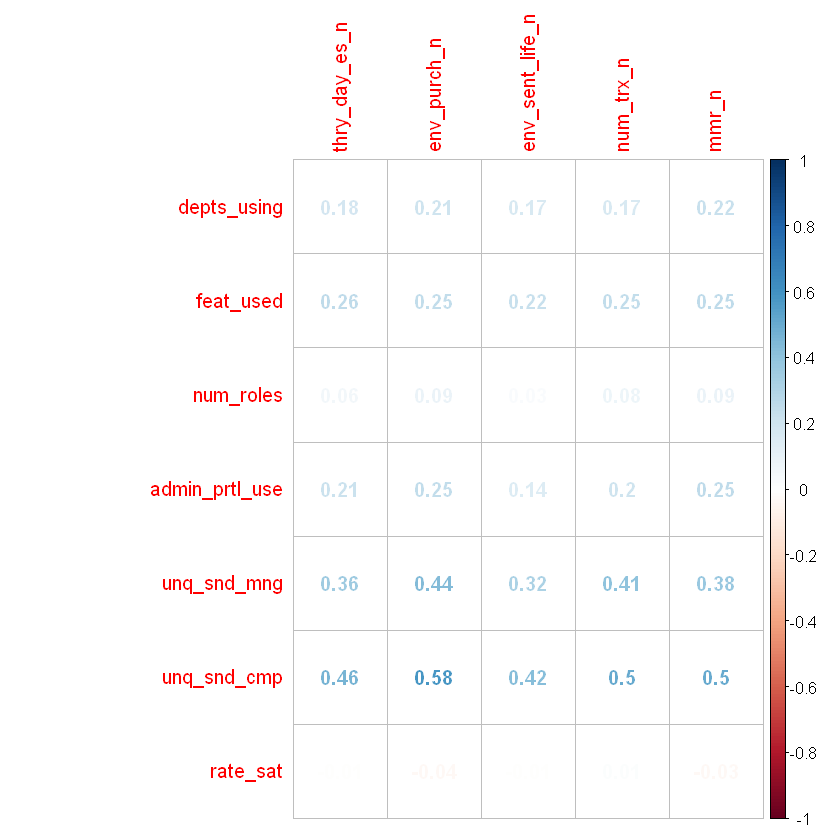

In [148]:
corrmatrix <- cor(df_norm_s, df_crm_i)
corrplot(corrmatrix, method = 'number')

# Correlation between GLRM PCAs and CRM Variables

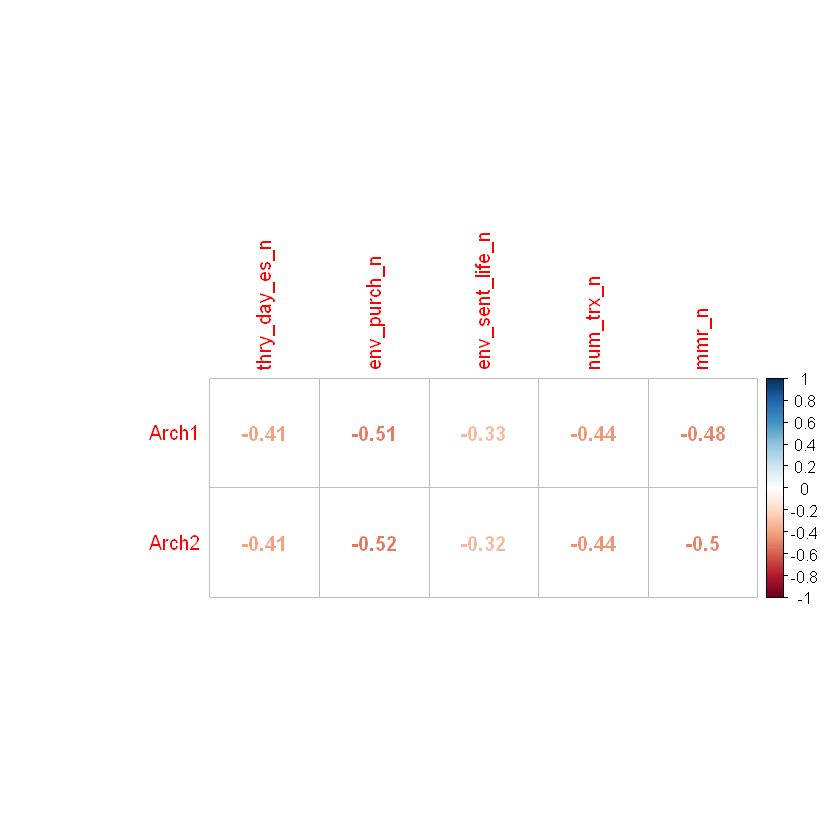

In [45]:
corrmatrix <- cor(X.m, df_crm_i)
corrplot(corrmatrix, method = 'number')

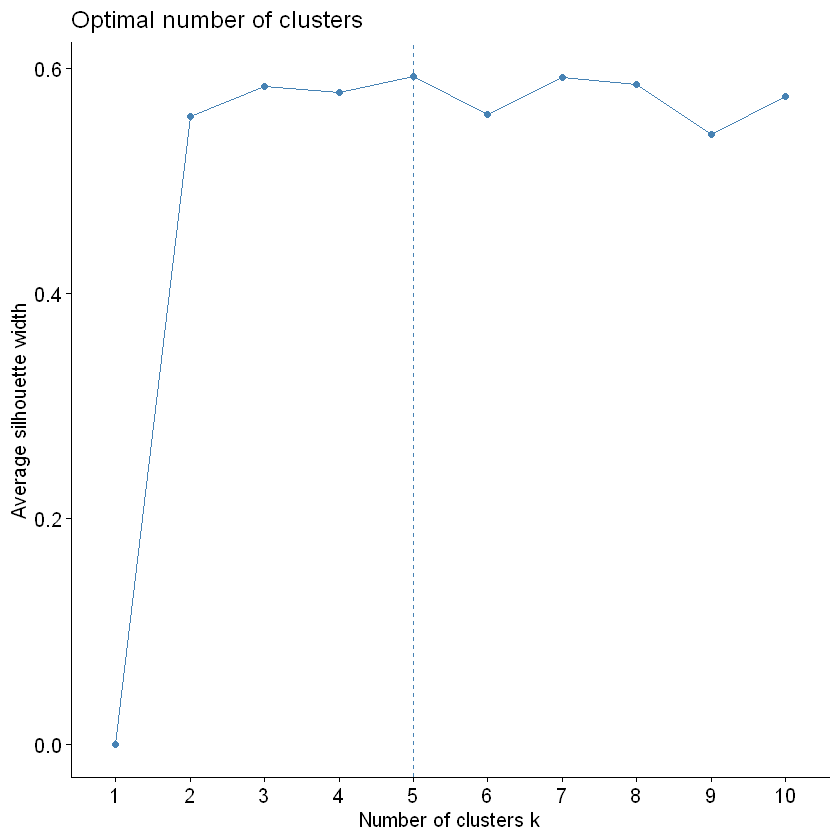

In [149]:
fviz_nbclust(X.m, kmeans, method='silhouette')

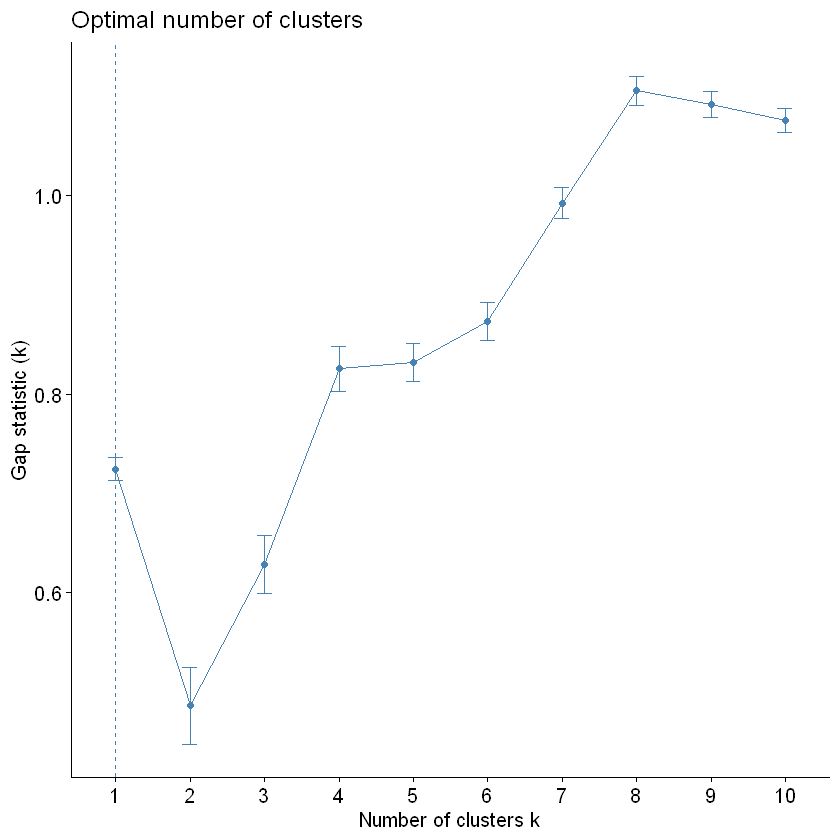

In [150]:
gap_stat <- clusGap(X.m, FUN = hcut, nstart = 25, K.max = 10, B = 50)
fviz_gap_stat(gap_stat)

# Code to Run All Dimension Reduction and Clustering Functions and Return Plots
<hr>

Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."


  |======================================================================| 100%
  |======================================================================| 100%
  cluster size ave.sil.width
1       1  344          0.52
2       2  143          0.50
3       3  636          0.64


Warning message in use.package("data.table"):
"data.table cannot be used without R package bit64 version 0.9.7 or higher.  Please upgrade to take advangage of data.table speedups."


  |======================================================================| 100%
  |======================================================================| 100%


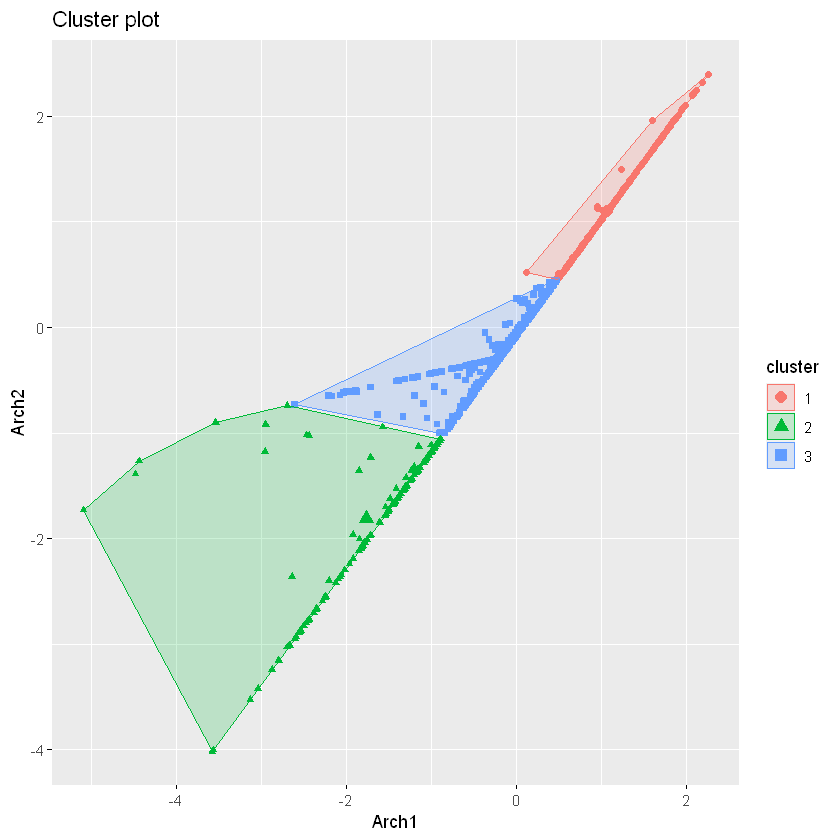

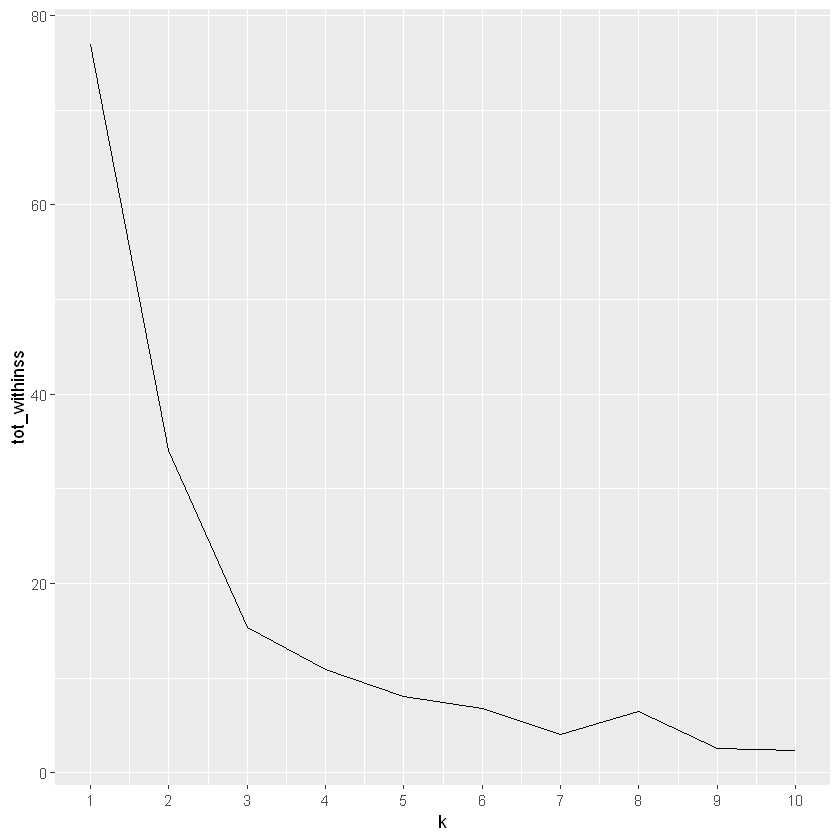

[1] "Training Confusion Matrix"


,1,2,3,Error,Rate
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,292,0,128,0.3047619,128 / 420
2,6,339,75,0.1928571,81 / 420
3,51,11,363,0.1458824,62 / 425
Totals,349,350,566,0.2142292,"271 / 1,265"


[1] "Validation Confusion Matrix"


,1,2,3,Error,Rate
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,33,2,84,0.7226891,86 / 119
2,1,7,37,0.8444444,38 / 45
3,24,4,183,0.1327014,28 / 211
Totals,58,13,304,0.4053333,152 / 375


[1] "Variable Importance"


variable,relative_importance,scaled_importance,percentage
<chr>,<dbl>,<dbl>,<dbl>
mmr_n,11593.961,1.0000000,0.3411820
env_purch_n,7338.535,0.6329619,0.2159552
num_trx_n,6458.486,0.5570560,0.1900575
thry_day_es_n,4780.500,0.4123267,0.1406785
env_sent_life_n,3810.265,0.3286422,0.1121268


,num_locs,dept,time_resp,time_ds_tasks,ds_expr,ds_role,ds_uni,vert,clusters
,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
1,6+,IT,General,Creating_Templates,Intermediate,Administrator (admin),No,Financial Services,2
2,2-5,Human resources,General,Generalist,Intermediate,Administrator (admin),No,Manufacturing,3
3,2-5,Legal,Legal,Sending_Envelopes,Advanced,Administrator (admin),No,Telecommunications,3
4,6+,IT,IT,Generalist,Intermediate,Administrator (admin),No,Technology,2
5,2-5,Other,General,Sending_Envelopes,Intermediate,Administrator (admin),No,Government,3
6,6+,IT,IT,Creating_Templates,Intermediate,Administrator (admin),No,Financial Services,2


clusters,num_locs,dept,time_resp,time_ds_tasks,ds_expr,ds_role,ds_uni,vert
<fct>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,1,Administration,General,Sending_Envelopes,Intermediate,Basic user,No,Other
2,6+,IT,IT,Generalist,Intermediate,Administrator (admin),Yes,Financial Services
3,2-5,IT,General,Generalist,Intermediate,Administrator (admin),No,Technology


clusters,V1,V2,V3,V4,V5,V6,V7,V8,V9
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2.453488,2.136628,1.305233,1.715116,12.25872,23.86337,20.14244,4.383721,3.674419
2,5.328671,6.055944,2.349650,4.664336,203.83916,890.31469,448.02797,4.440559,4.146853
3,3.455975,3.690252,1.641509,3.084906,22.16667,107.57704,13.16667,4.386792,3.949686


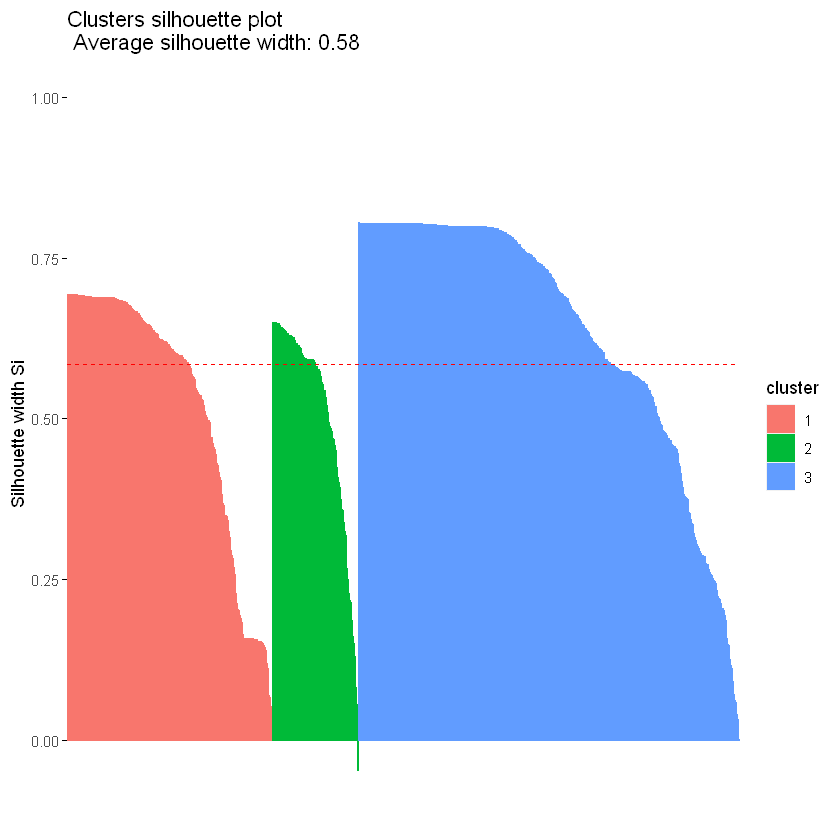

In [157]:
comps = 2   # Specify the number of PCA components (> 2) 
clusters = 3 # specify the number of clusters
ag = 'kmeans'  #choose the algorith: 'kmeans' = kmeans, 'hier' = Hierarchical, 'gmm' = Gaussian Mixture Model  
trees = 300
depth = 11


# This runs all the reduction and clustering functions and returns the result. 
res <- run_h2(df_all,comps,clusters, ag, trees, depth)  


# return specific elements from the functions
res[[2]]
res[[3]]
res[[4]]

print("Training Confusion Matrix")
res[[1]][[3]]
print("Validation Confusion Matrix")
res[[1]][[4]]
print("Variable Importance")
res[[1]][[5]]


# This saves the new dataframe with the clusters 
res.crm = as.data.frame(res[[1]][[2]])

df_c_summary <- df_c_s
df_c_summary$clusters <- res.crm$clusters
head(df_c_summary)

df_n_summary <- as.data.frame(df_scale)
df_n_summary$clusters <- res.crm$clusters

df_c_summary %>% 
  group_by(clusters) %>% 
  summarise_if(is.factor, .funs = function(x) { x %>% table %>% which.max %>% names})

df_n_summary %>% 
  group_by(clusters) %>% 
  summarise_if(is.numeric, funs(mean(., na.rm=TRUE)))

In [168]:
df_n_summary <- as.data.frame(df_norm)
df_n_summary$clusters <- res.crm$clusters


df_n_summary %>% 
  group_by(clusters) %>% 
  summarise_if(is.numeric, funs(mean(., na.rm=TRUE)))

clusters,q4n,q5n,q6n,q7n,q8n,q9n,q10n,q11n,q12n,q13n
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2.470588,-0.708078,1.302941,-0.8211004,-0.56093744,-0.56459481,-0.24593095,-0.07156078,-0.04648756,-0.25096108
2,5.340278,1.127418,2.326389,1.1361808,1.06058630,1.08398150,0.24761563,0.14216775,0.03687807,0.24222605
3,3.435055,0.122689,1.644757,0.1808515,0.07219958,0.06691712,0.07505458,0.00591409,0.01642462,0.07894556


# Comparison to Original Segmentation (Paradoxes)

In [158]:
data1 <- res.crm
data1$orig_clust <- oc
data1$clusters <- factor((data1$clusters), labels=c("s1", "s2", "s3"))
data1$clust_num = res.crm$clusters

In [159]:
#data1$crm_clust <-crm_km$cluster
#data1
chisq.test(table(data1$orig_clust, data1$clusters))
table(data1$orig_clust, data1$clusters)


	Pearson's Chi-squared test

data:  table(data1$orig_clust, data1$clusters)
X-squared = 536.12, df = 6, p-value < 2.2e-16


             
               s1  s2  s3
  basic_user  216   5 172
  entry_level  64  47 350
  non_engaged  63   0  15
  power_admin   1  91  99

# Multinomial Logistic Regression
<hr>

In [49]:
library(nnet)

In [160]:
df_mn <- res.crm
df_mn$clusters <- factor((df_mn$clusters), labels=c("s1", "s2", "s3"))
#df_mn$clusters <- as.factor(df_mn$clusters)
dim(df_mn)

[1] 1123    6

In [161]:
index <- createDataPartition(df_mn$clusters, p = .70, list=FALSE)
train <- df_mn[index,]
test <- df_mn[-index,]

In [162]:
df_mn$clusters <- relevel(df_mn$clusters, ref = "s1")
train$clusters <- relevel(train$clusters, ref = "s1")
test$clusters <- relevel(test$clusters, ref = "s1")

In [163]:
multinom_model <- multinom(clusters ~ ., data = df_mn)

# weights:  21 (12 variable)
initial  value 1233.741600 
iter  10 value 994.438262
iter  20 value 903.004790
final  value 902.998919 
converged


In [164]:
summary(multinom_model)

Call:
multinom(formula = clusters ~ ., data = df_mn)

Coefficients:
   (Intercept) thry_day_es_n env_purch_n env_sent_life_n    num_trx_n     mmr_n
s2  -1.4006668     0.3326556   1.2808761      -0.5496012 0.4325563898 0.7897573
s3   0.8381161     0.2677741   0.4507431      -0.2331353 0.0005329961 0.4535447

Std. Errors:
   (Intercept) thry_day_es_n env_purch_n env_sent_life_n num_trx_n     mmr_n
s2  0.15666069     0.2890227   0.2222680       0.2278335 0.2317216 0.2093813
s3  0.07778533     0.1580367   0.1180708       0.1296093 0.1375675 0.1142237

Residual Deviance: 1805.998 
AIC: 1829.998 

In [165]:
z <- summary(multinom_model)$coefficients/summary(multinom_model)$standard.errors
# 2-tailed Wald z tests to test significance of coefficients
p <- (1 - pnorm(abs(z), 0, 1)) * 2
p

,(Intercept),thry_day_es_n,env_purch_n,env_sent_life_n,num_trx_n,mmr_n
s2,0,0.24974579,8.275199e-09,0.01585252,0.0619425,1.620336e-04
s3,0,0.09019331,1.347744e-04,0.07205766,0.9969087,7.167002e-05


In [166]:
exp(coef(multinom_model))

,(Intercept),thry_day_es_n,env_purch_n,env_sent_life_n,num_trx_n,mmr_n
s2,0.2464326,1.394667,3.599792,0.5771799,1.541192,2.202862
s3,2.3120073,1.307052,1.569478,0.7920464,1.000533,1.573881


In [167]:
# Predicting the values for train dataset
train$clusterPredicted <- predict(multinom_model, newdata=train, type="class")
# Building classification table
tab <- table(train$clusterPredicted, train$clusters)
# Confusion Matrix
confusionMatrix(train$clusters, train$clusterPredicted)

Confusion Matrix and Statistics

          Reference
Prediction  s1  s2  s3
        s1  86   3 152
        s2   2  25  74
        s3  58  10 378

Overall Statistics
                                          
               Accuracy : 0.6206          
                 95% CI : (0.5856, 0.6546)
    No Information Rate : 0.7665          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.2461          
                                          
 Mcnemar's Test P-Value : <2e-16          

Statistics by Class:

                     Class: s1 Class: s2 Class: s3
Sensitivity             0.5890   0.65789    0.6258
Specificity             0.7586   0.89867    0.6304
Pos Pred Value          0.3568   0.24752    0.8475
Neg Pred Value          0.8903   0.98108    0.3392
Prevalence              0.1853   0.04822    0.7665
Detection Rate          0.1091   0.03173    0.4797
Detection Prevalence    0.3058   0.12817    0.5660
Balanced Accuracy

In [168]:
# Predicting the class for test dataset
test$clusterPredicted <- predict(multinom_model, newdata = test, type="class")
# Building classification table
tab <- table(test$clusters, test$clusterPredicted)
confusionMatrix(test$clusters,test$clusterPredicted)

Confusion Matrix and Statistics

          Reference
Prediction  s1  s2  s3
        s1  44   0  59
        s2   1   5  36
        s3  39   6 145

Overall Statistics
                                          
               Accuracy : 0.5791          
                 95% CI : (0.5242, 0.6326)
    No Information Rate : 0.7164          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.1787          
                                          
 Mcnemar's Test P-Value : 7.457e-06       

Statistics by Class:

                     Class: s1 Class: s2 Class: s3
Sensitivity             0.5238   0.45455    0.6042
Specificity             0.7649   0.88580    0.5263
Pos Pred Value          0.4272   0.11905    0.7632
Neg Pred Value          0.8276   0.97952    0.3448
Prevalence              0.2507   0.03284    0.7164
Detection Rate          0.1313   0.01493    0.4328
Detection Prevalence    0.3075   0.12537    0.5672
Balanced Accuracy

# K-Prototypes
<hr>

With K-Prototypes we can use a mixture of numeric and categorical variables in the model.  For this analysis we have first applied PCA to only the numberic variables in the dataset and then appended the categorical variables to the PCAs to create a unified dataset.  Once created, we applied the K-Prototypes algorithm to the entire set of variables. 
<hr>

# NAs in variables:
   depts_using      feat_used      num_roles admin_prtl_use    unq_snd_mng 
             0              0              0              0              0 
   unq_snd_cmp       rate_sat       num_locs           dept      time_resp 
             0              0              0              0              0 
 time_ds_tasks        ds_expr        ds_role         ds_uni           vert 
             0              0              0              0              0 
0 observation(s) with NAs.

Estimated lambda: 1.541568 

# NAs in variables:
   depts_using      feat_used      num_roles admin_prtl_use    unq_snd_mng 
             0              0              0              0              0 
   unq_snd_cmp       rate_sat       num_locs           dept      time_resp 
             0              0              0              0              0 
 time_ds_tasks        ds_expr        ds_role         ds_uni           vert 
             0              0              0              0        

[1] 15017.65 12837.62 12135.93 11668.48 11277.38 10828.37 10585.15

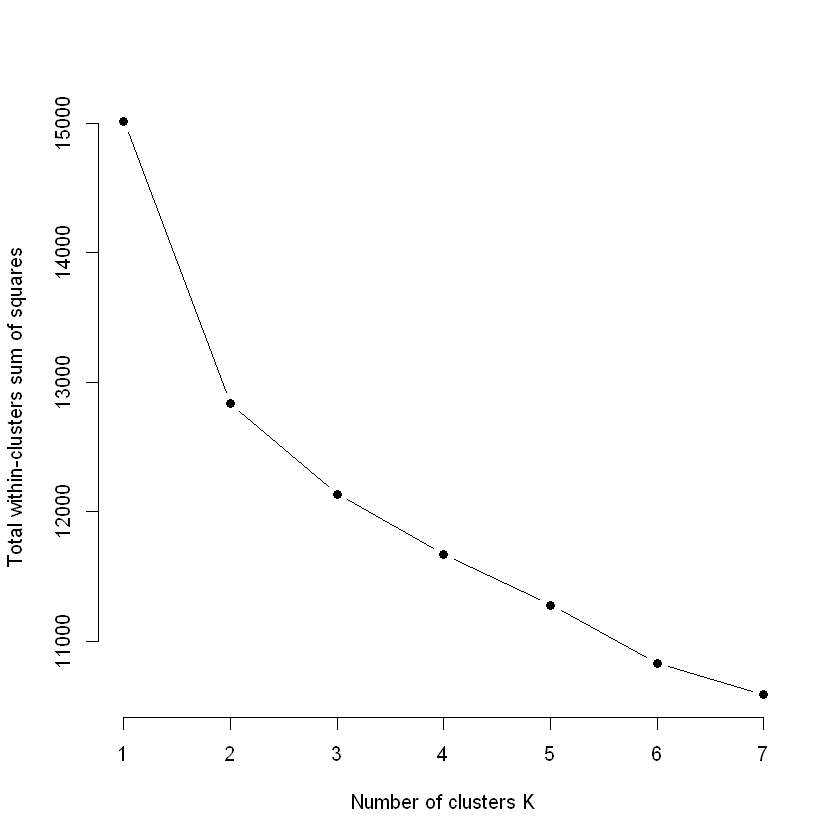

In [133]:
# Combine the PCAs from the numerical dataset and the categorical variables into a single DataFrame
  df_kp <-df_all    
  
#algorithm to find the optimal number of K-Prototypes clusters
# Compute and plot wss for k = 2 to k = 15.
  k.max <- 7
  data <- na.omit(df_kp) # to remove the rows with NA's
  wss <- sapply(1:k.max, 
                function(k){kproto(data, k)$tot.withinss})
  wss
  plot(1:k.max, wss,
       type="b", pch = 19, frame = FALSE, 
       xlab="Number of clusters K",
       ylab="Total within-clusters sum of squares")



In [134]:
dim(df_all)

[1] 1123   15

[1] 1123

[1] 0.1634262

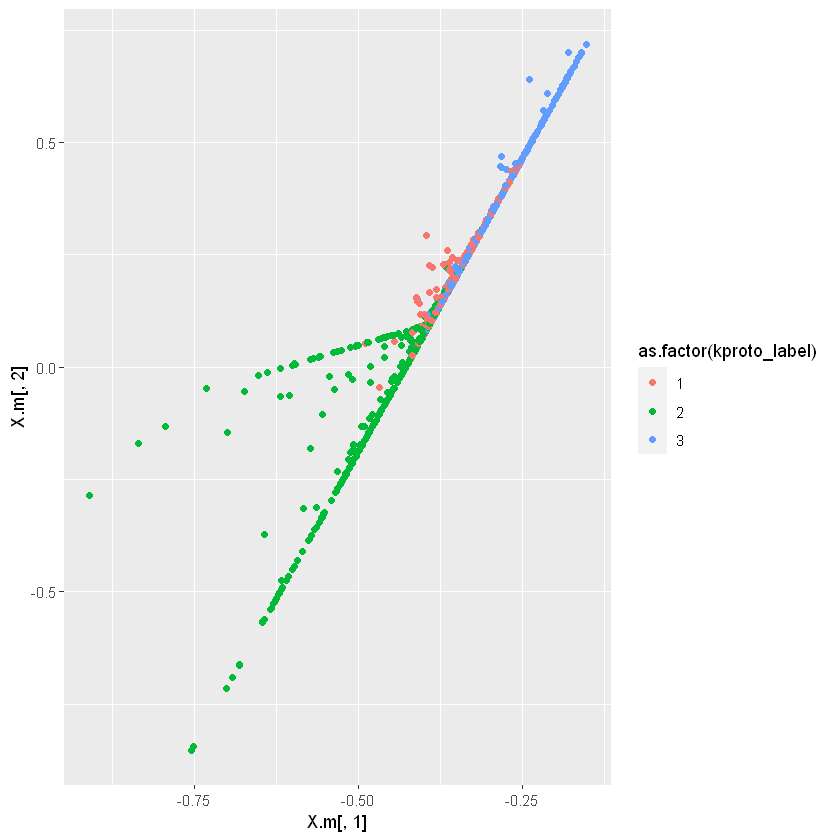

In [174]:
# Run the K Prototype Algorithm 
  kpres <- kproto(df_kp, 3, iter.max=20, nstart=15, keep.data=TRUE, verbose=FALSE)
  kproto_label <- kpres$cluster
  length(kproto_label)
  
  ggplot() + geom_point(data = as.data.frame(X.m), mapping = aes(x = X.m[,1], y = X.m[,2], col = as.factor(kproto_label))) + scale_fill_brewer(palette="Set1")

  
  # calculate index-value
  val <- validation_kproto(method = "silhouette", object=kpres, data = df_kp, k = 2:5, nstart = 15)
  val

In [175]:
kpres

Numeric predictors: 7 
Categorical predictors: 8 
Lambda: 1.541568 

Number of Clusters: 3 
Cluster sizes: 343 433 347 
Within cluster error: 3309.35 4774.976 3970.473 

Cluster prototypes:
  depts_using  feat_used num_roles admin_prtl_use unq_snd_mng unq_snd_cmp
1  -0.1378614  0.2610503  1.758017      0.3705006  -0.6203295  -0.7563909
2   0.4307001  0.5281067  1.838337      0.5887428   0.7133519   0.7829930
3  -0.4011721 -0.9170331  1.239193     -1.1008857  -0.2535075  -0.2095181
      rate_sat num_locs           dept time_resp     time_ds_tasks      ds_expr
1  0.149009861        1 Administration   General Sending_Envelopes Intermediate
2 -0.005900468       6+             IT   General        Generalist Intermediate
3 -0.139929336        1          Sales   General Sending_Envelopes Intermediate
                ds_role ds_uni               vert
1 Administrator (admin)     No              Other
2 Administrator (admin)     No Financial Services
3            Basic user     No  Business Ser

In [176]:
kp_crm <- df_crm_i

In [177]:
kp_crm <- as.data.frame(kp_crm)
kp_crm$clusters = kpres$cluster

In [178]:
## Random Forest 
  rf_classifier = randomForest(as.factor(clusters) ~ ., data=na.omit(kp_crm), ntree=2000, mtry=2, importance=TRUE)
  rf_classifier


# ANOVA 
  anova <- aov(clusters ~ ., data = na.omit(kp_crm))
  summary(anova)
  
# Cluster Profiles 
  #clprofiles(kpres, df_kp)


Call:
 randomForest(formula = as.factor(clusters) ~ ., data = na.omit(kp_crm),      ntree = 2000, mtry = 2, importance = TRUE) 
               Type of random forest: classification
                     Number of trees: 2000
No. of variables tried at each split: 2

        OOB estimate of  error rate: 48.8%
Confusion matrix:
    1   2   3 class.error
1 141  76 126   0.5889213
2  56 323  54   0.2540416
3 130 106 111   0.6801153

                  Df Sum Sq Mean Sq F value  Pr(>F)   
thry_day_es_n      1    0.1   0.135   0.221 0.63810   
env_purch_n        1    4.1   4.080   6.673 0.00991 **
env_sent_life_n    1    0.0   0.031   0.051 0.82139   
num_trx_n          1    1.9   1.882   3.078 0.07963 . 
mmr_n              1    0.9   0.937   1.533 0.21592   
Residuals       1117  682.9   0.611                   
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

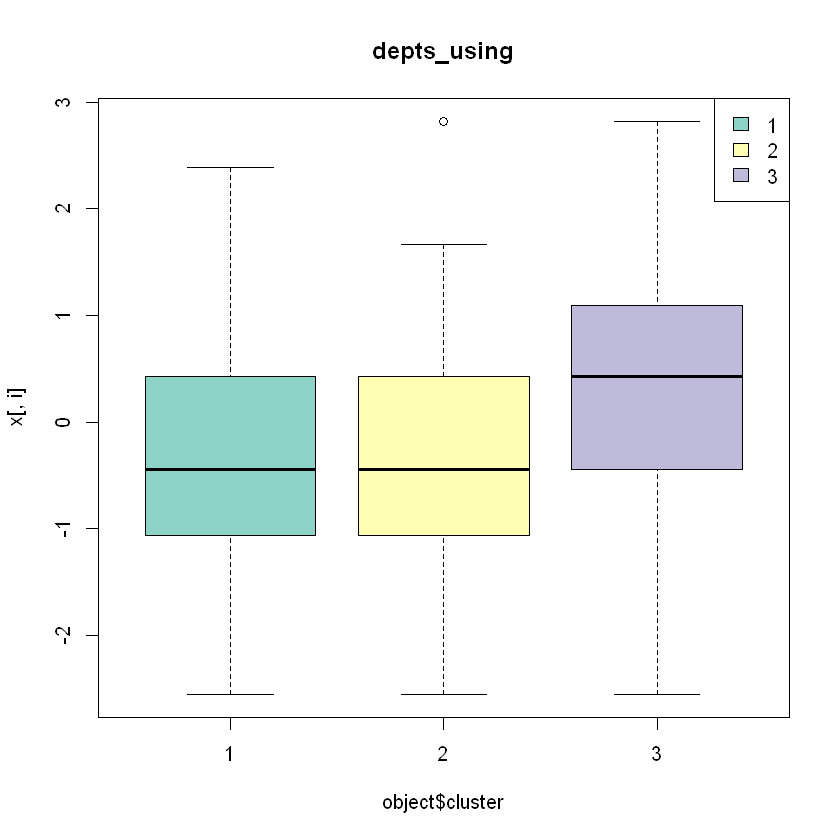

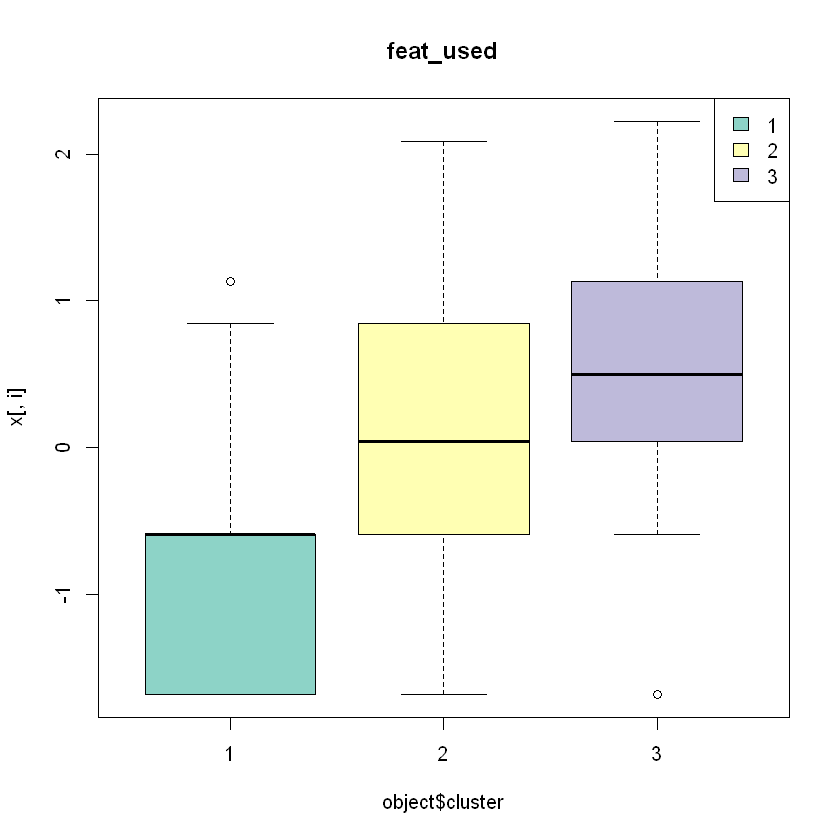

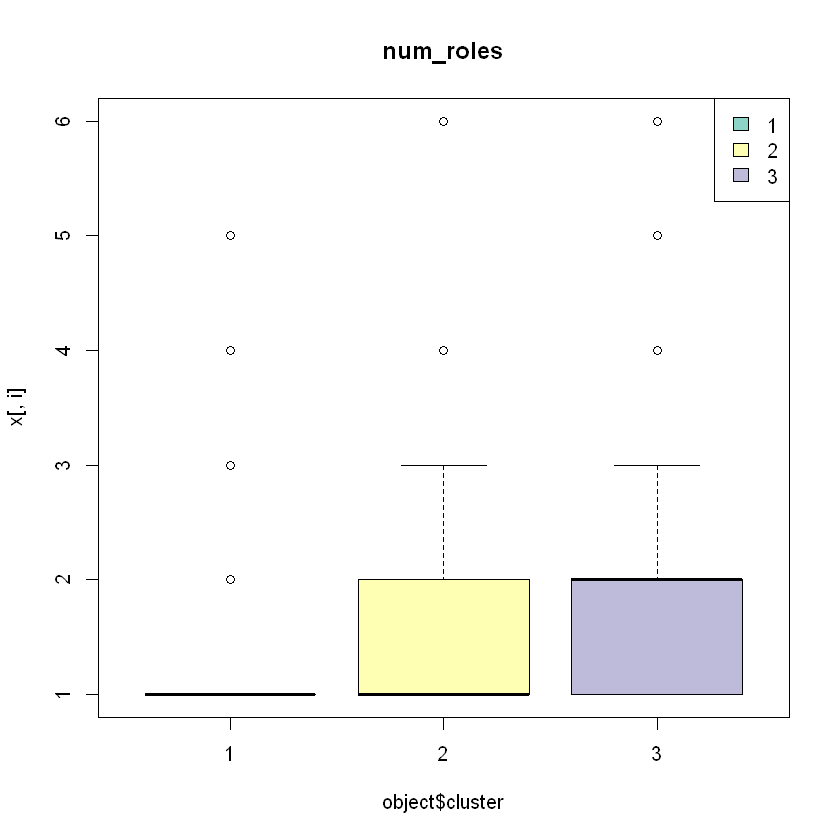

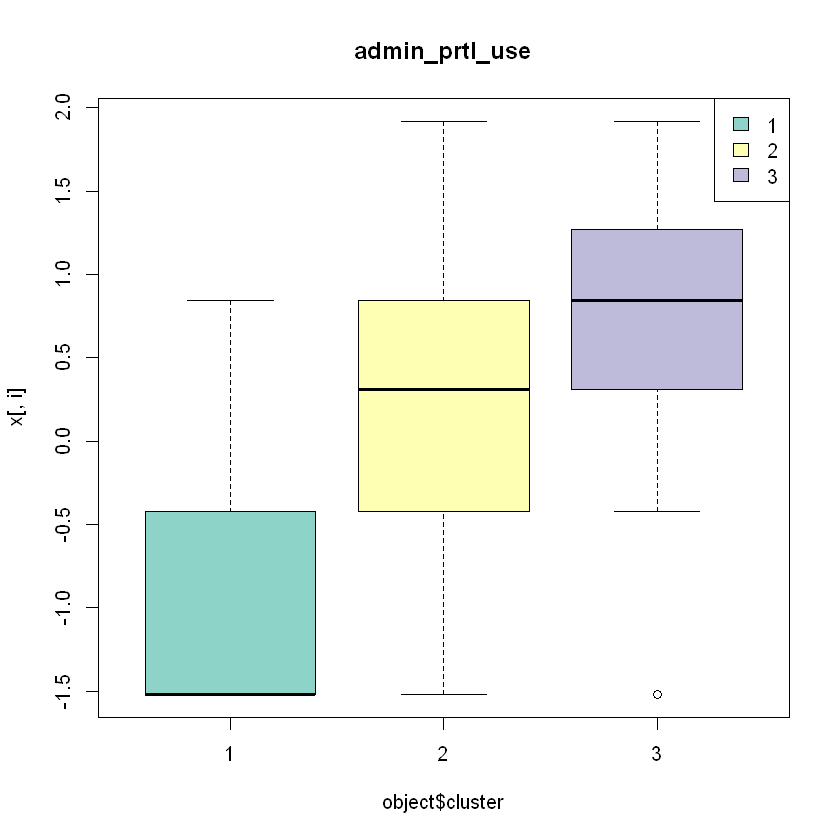

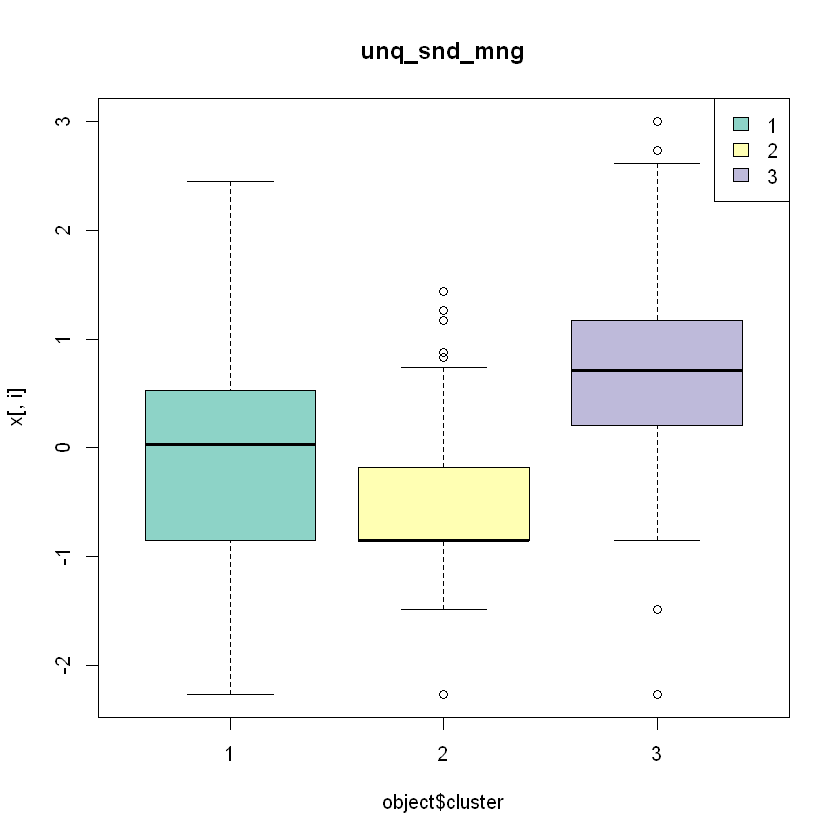

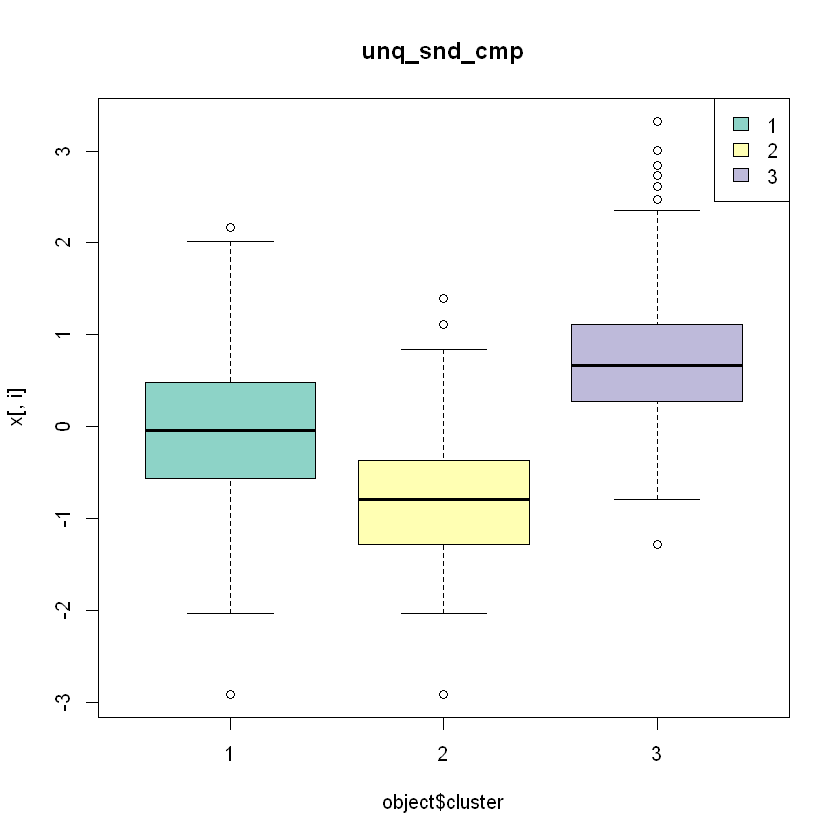

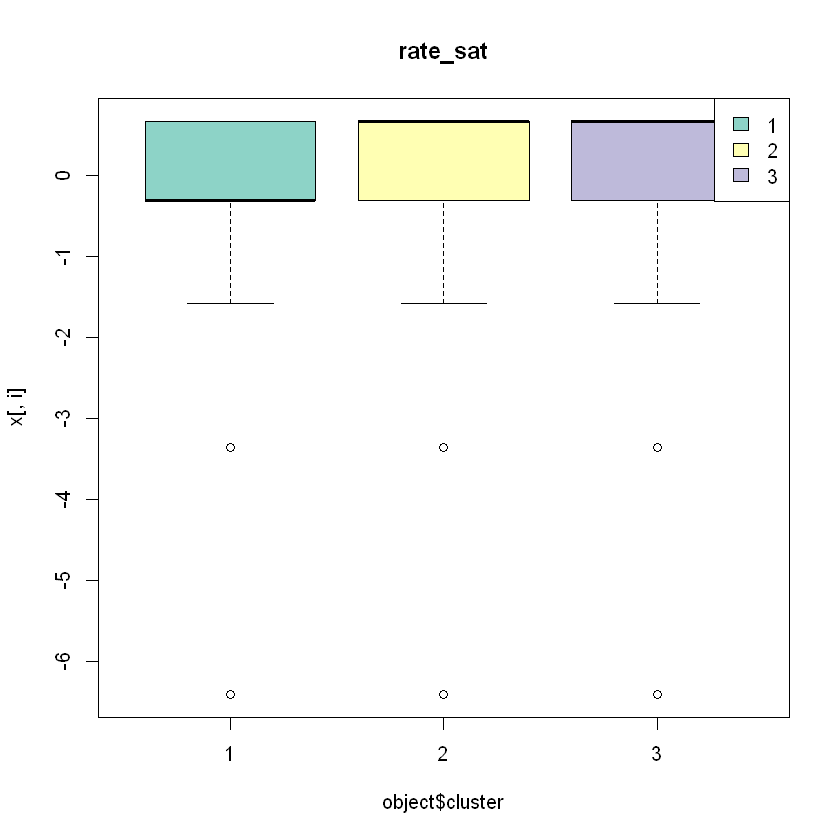

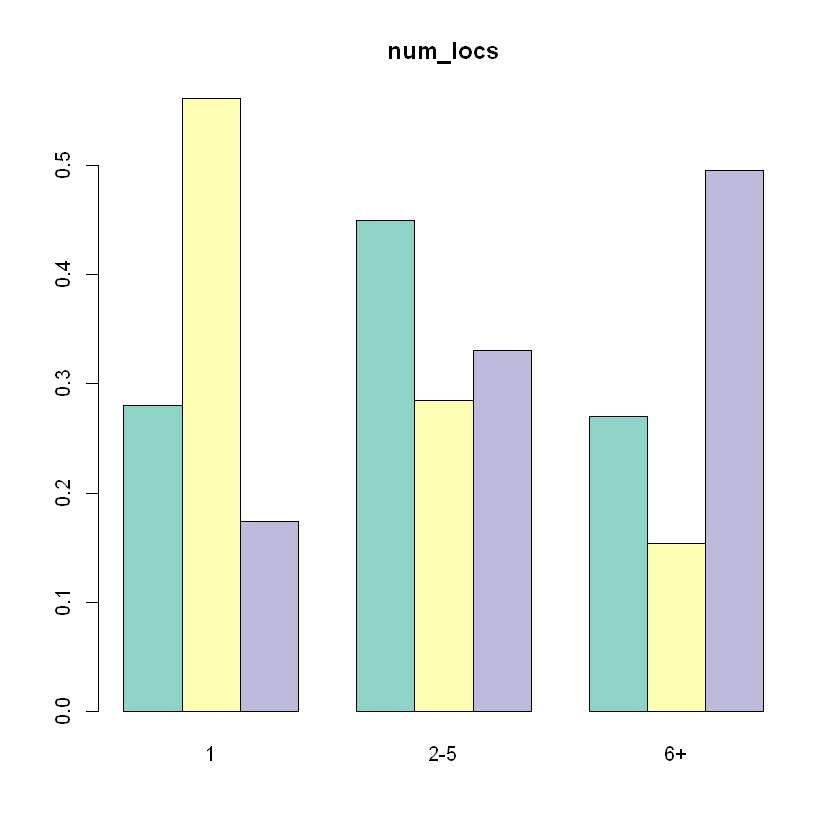

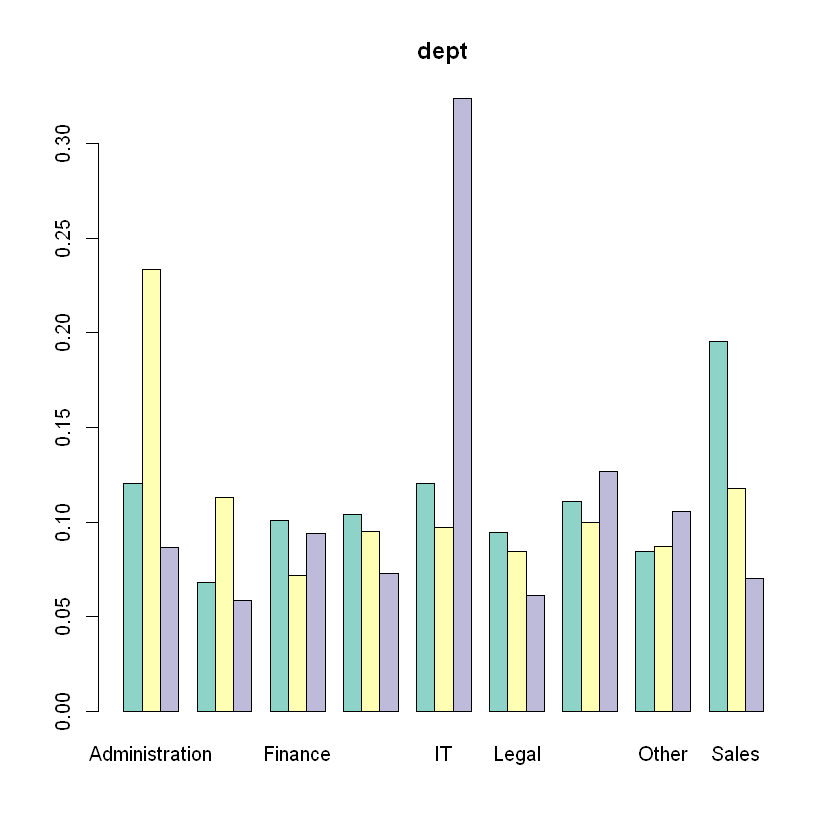

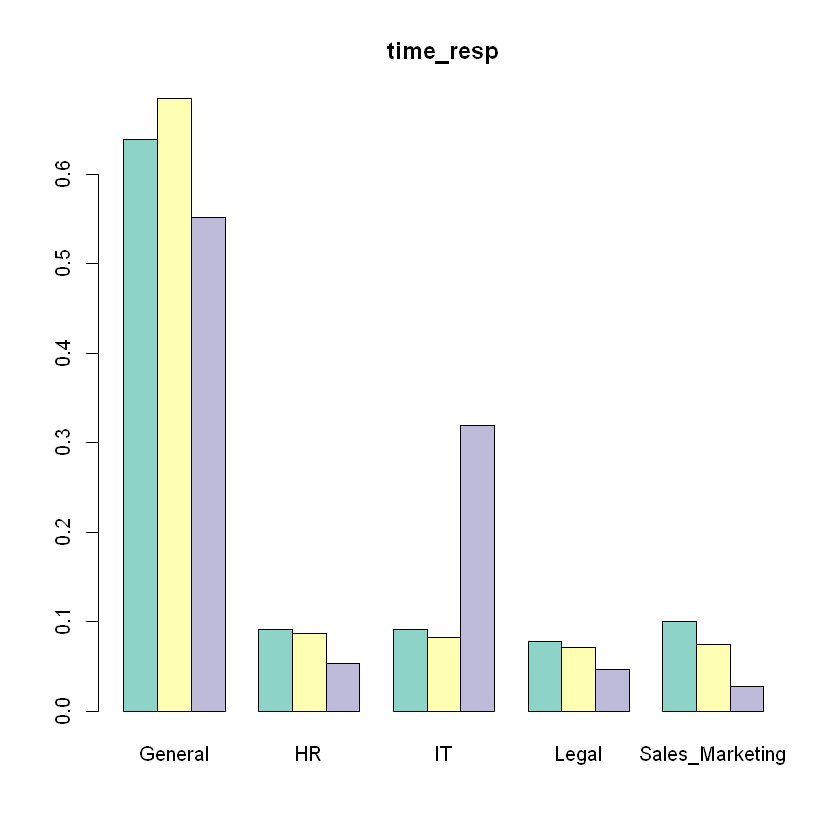

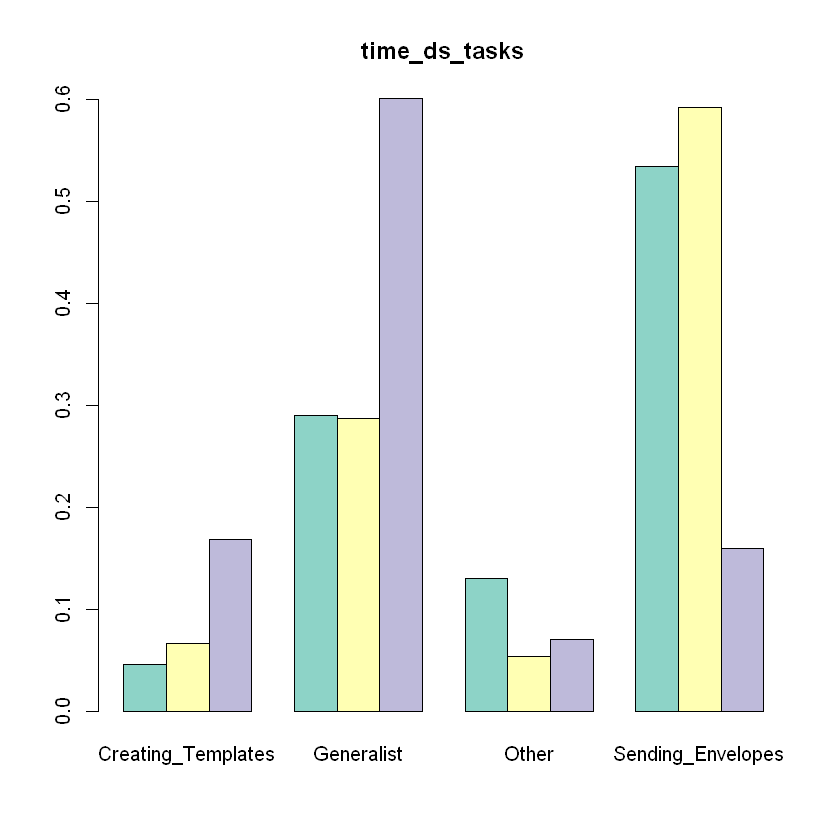

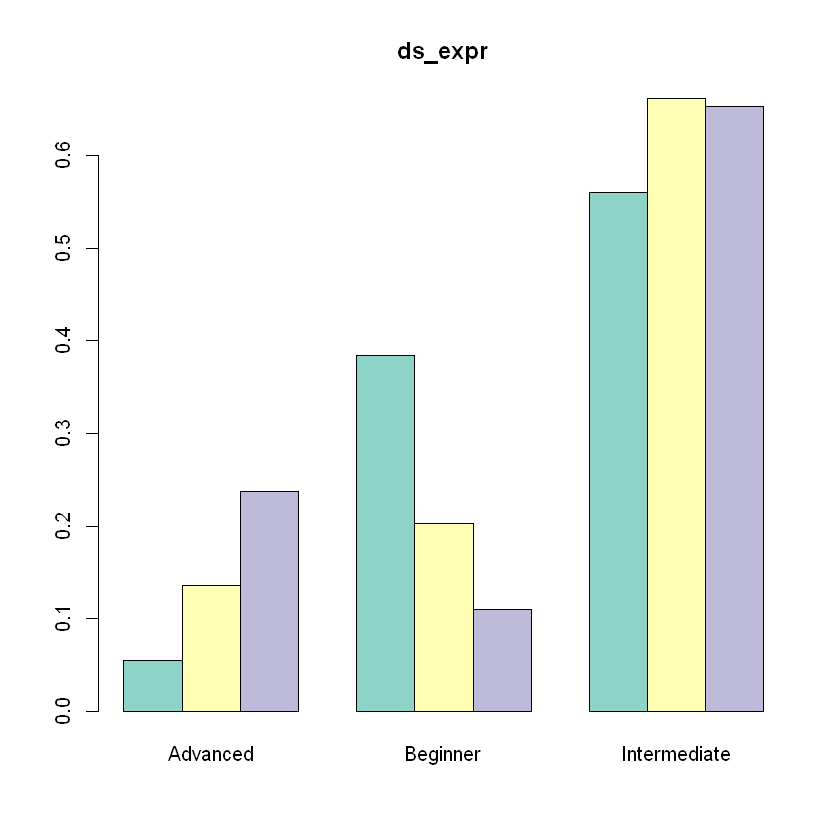

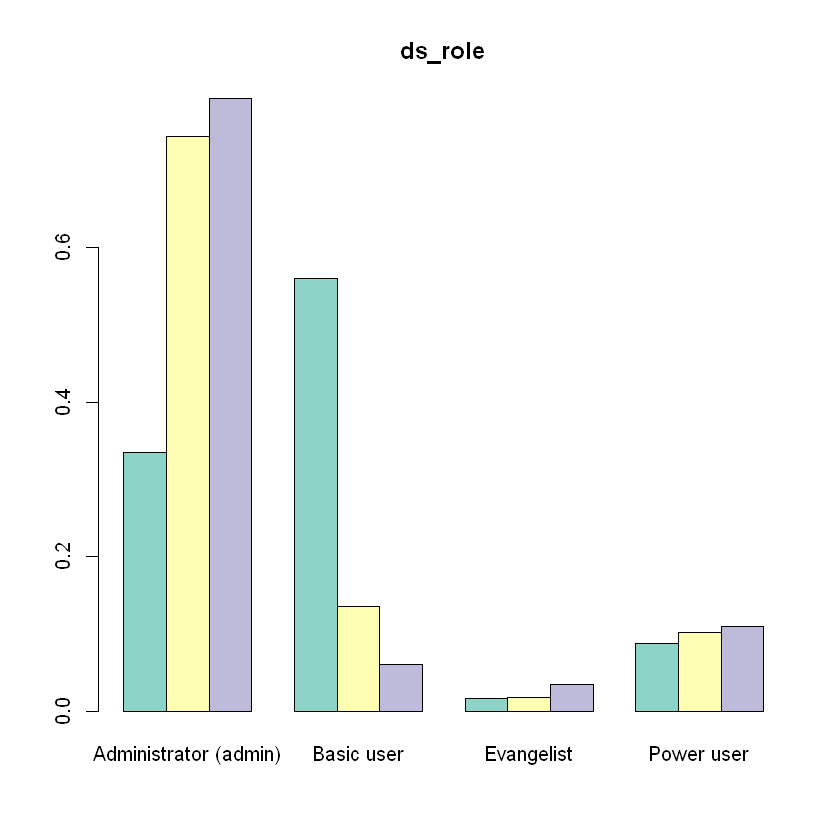

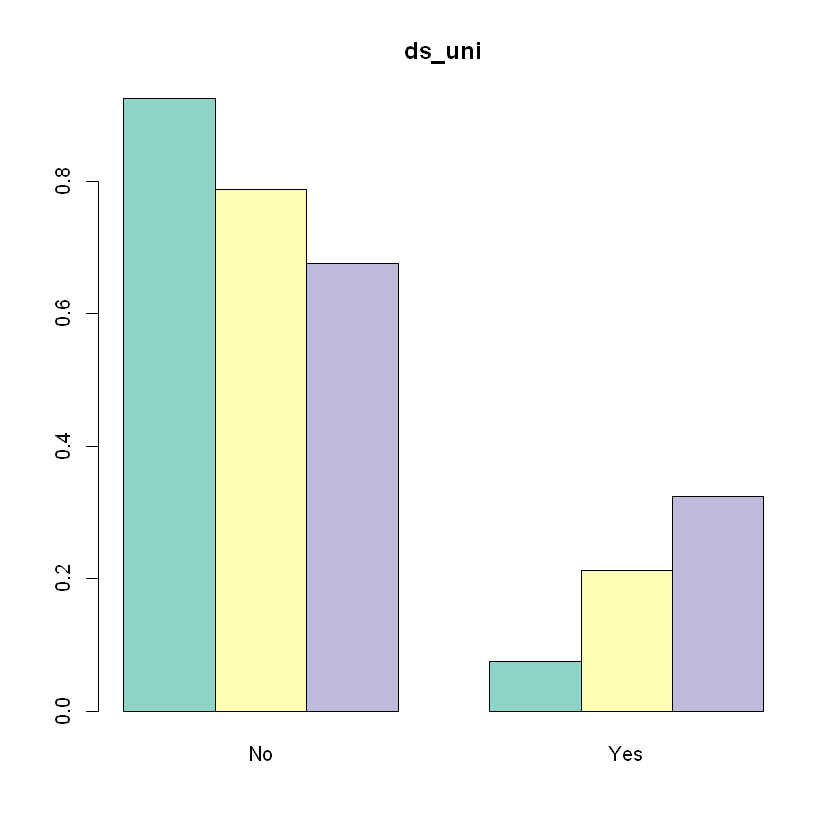

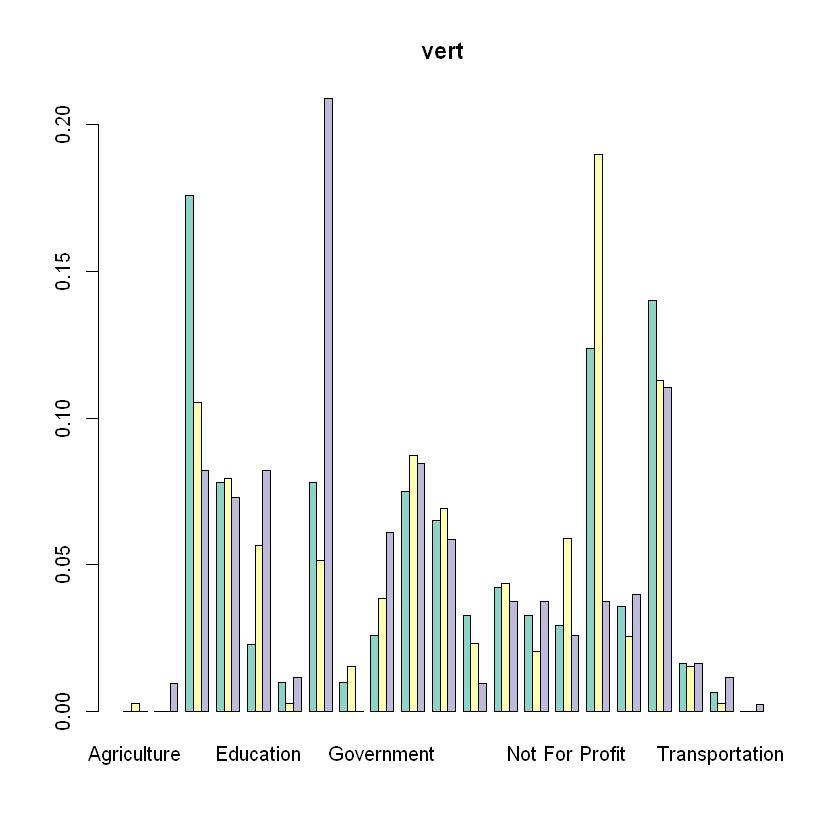

In [139]:
# Cluster Profiles 
clprofiles(kpres, df_all)